In [4]:
%pip install sklearn
%pip install scikit-learn
%pip install matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import json

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

# IN DOMAIN EXPERIMENTS

## ENGLISH
We train the model with the train and dev set. We get the predictions made by the model for the test in English language, and then we use the predictions together with the gold standar to get the accuracy.

In [32]:
lang = "English"
ruta_archivo = f"output/test_{lang}_predictions.jsonl"

all_tags = []
all_predictions = []

# read de jsonl file and process it
with open(ruta_archivo, "r", encoding="utf-8") as archivo:
    contenido = archivo.read()
    contenido = "[" + contenido.strip().replace("}\n{", "},{") + "]"
    elementos = json.loads(contenido)
    #print(len(elementos[0]))

# get the tag and prediction of each instance and concatenate them
errors = {}
for elemento in elementos:
    correct_tags = elemento.get("tags", [])
    predicted_tags = elemento.get("prediction", [])
    for i in range(len(correct_tags)):
        correct_tag = correct_tags[i]
        predicted_tag = predicted_tags[i]
        if correct_tag != predicted_tag:
            if predicted_tag in ["ADJ", "NOUN", "VERB"]:
                # we check what is the wrong tagged word
                word = elemento.get("sentence", "").split()[i]
                if f"{correct_tag},{predicted_tag}" not in errors:
                    errors[f"{correct_tag},{predicted_tag}"] = [word]
                else:
                    errors[f"{correct_tag},{predicted_tag}"].append(word)


    all_tags.extend(elemento.get("tags", []))
    all_predictions.extend(elemento.get("prediction", []))



**Accuracy score of the English model**

In [33]:
accuracy = accuracy_score(all_tags, all_predictions)
accuracy

0.8678194607268465

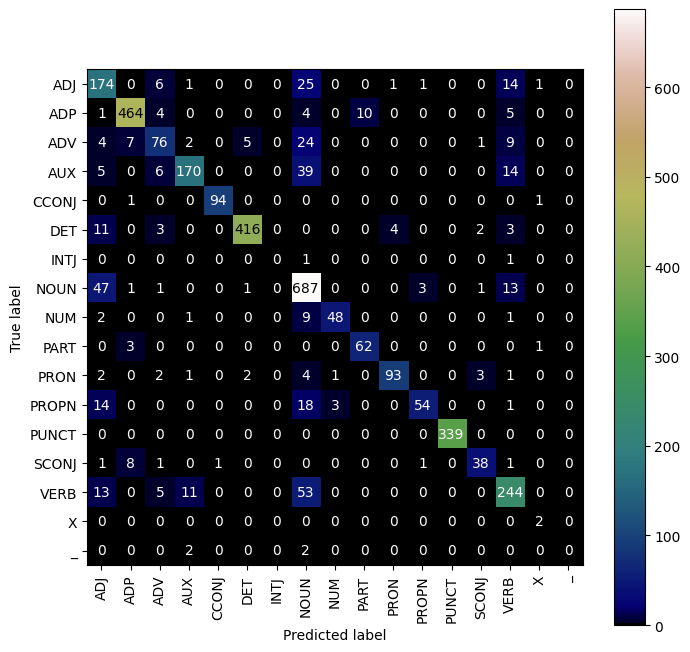

In [36]:
#create the confusion matrix
tags_set = sorted(set(all_tags))
cm=confusion_matrix(all_tags, all_predictions, labels=tags_set)
cm

#show the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags_set)
disp.plot(cmap="gist_earth", ax=ax, xticks_rotation="vertical")

plt.show()

The confusion matrix shows that there is high correlation between the actual tags and the model's predictions. Overall, the number of errors is low in all tags and the accuracy score is high (0.86). However, the model does some errors for the NOUN tag. This tag is the most common one in the train set. The NOUN is confused with the tag VERB 53 times

FREQUENT INCORRECT WORDS ANALYSIS

(Real Tag, Predicted Tag) [words frequency]

In [35]:
from collections import Counter
#print each type
#ADJ
for check_tag in ["ADJ", "NOUN", "VERB"]:
    print(f"-------{check_tag}--------")
    for tags,value in errors.items():
        if tags.split(",")[1] == check_tag:
            # Contar la cantidad de repeticiones de cada palabra
            word_counts = Counter(value)

            # Filtrar las palabras que aparecen más de una vez
            filtered_word_counts = {word: count for word, count in word_counts.items() if count > 1}

            # Ordenar las palabras por su frecuencia de mayor a menor
            sorted_filtered_word_counts = sorted(filtered_word_counts.items(), key=lambda x: x[1], reverse=True)
            if sorted_filtered_word_counts:
                print(tags, sorted_filtered_word_counts)
                print()

-------ADJ--------
NOUN,ADJ [('accession', 3), ('minimum', 2), ('Treaty', 2), ('Article', 2), ('Judges', 2)]

DET,ADJ [('such', 4), ('each', 3), ('my', 2), ('those', 2)]

PROPN,ADJ [('European', 3), ('General', 3), ('Romanian', 2)]

AUX,ADJ [('shall', 5)]

ADV,ADJ [('long', 2)]

-------NOUN--------
NUM,NOUN [('2008', 2)]

VERB,NOUN [('expire', 7), ('made', 2), ('provided', 2), ('specified', 2), ('believe', 2)]

ADJ,NOUN [('appointed', 3), ('necessary', 2), ('base', 2)]

PROPN,NOUN [('Union', 3), ('Bulgarian', 2), ('Romania', 2), ('Justice', 2)]

ADV,NOUN [('part', 3), ('least', 2), ('thereto', 2), ('longer', 2)]

AUX,NOUN [('shall', 36), ('may', 2)]

PRON,NOUN [('those', 3)]

_,NOUN [("ain't", 2)]

-------VERB--------
ADP,VERB [('under', 3)]

ADJ,VERB [('appointed', 2)]

AUX,VERB [('shall', 5), ('is', 3), ('may', 3)]

DET,VERB [('such', 3)]



## SPANISH

In [58]:
lang = "Spanish"
ruta_archivo = f"output/test_{lang}_predictions.jsonl"

all_tags = []
all_predictions = []

# read de jsonl file and process it
with open(ruta_archivo, "r", encoding="utf-8") as archivo:
    contenido = archivo.read()
    contenido = "[" + contenido.strip().replace("}\n{", "},{") + "]"
    elementos = json.loads(contenido)
    #print(len(elementos[0]))

# get the tag and prediction of each instance and concatenate them
for elemento in elementos:
    all_tags.extend(elemento.get("tags", []))
    all_predictions.extend(elemento.get("prediction", []))


In [59]:
accuracy = accuracy_score(all_tags, all_predictions)
accuracy

0.9238956509232125

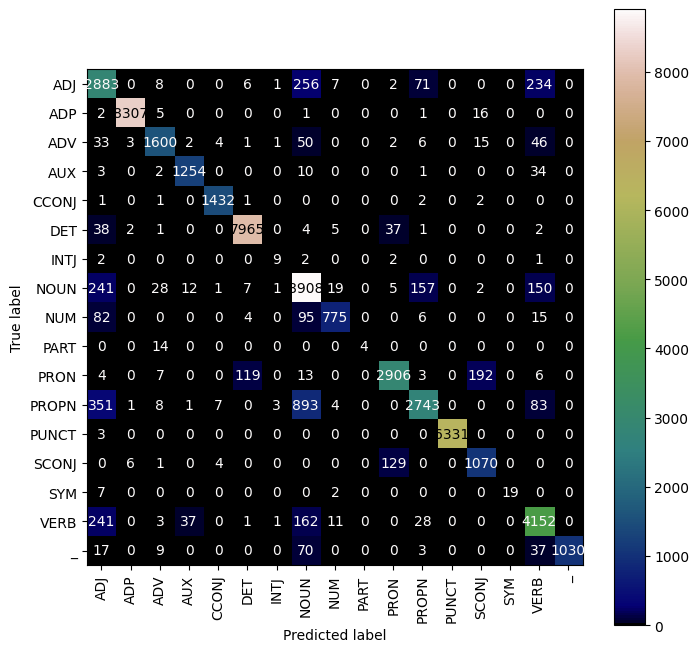

In [60]:
accuracy
#create the confusion matrix
tags_set = sorted(set(all_predictions))
cm = confusion_matrix(all_tags, all_predictions, labels=tags_set)
cm

#show the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags_set)
disp.plot(cmap="gist_earth", ax=ax, xticks_rotation="vertical")

plt.show()

As in English, the confusion matrix for Spanish shows that there is also high correlation between the predictions and the actual clases in Spanish. However, in Spanish, the model makes more errors and it is reflected both in the matrix and in the slightly lower accuracy score (0.88). In this case, it is worth mentioning that the tags that the model confuses the most are the NOUN and PROPN. As the NOUN and PROPN are similar between them, this error is understandable. Also, the model makes a remarkable number of errors with tags like VERB or PUNCT.

## OUT-OF-DOMAIN RESULTS

# ENGLISH

In [61]:
lang = "English"
ruta_archivo = f"output/od_{lang}_predictions.jsonl"

all_tags = []
all_predictions = []

# read de jsonl file and process it
with open(ruta_archivo, "r", encoding="utf-8") as archivo:
    contenido = archivo.read()
    contenido = "[" + contenido.strip().replace("}\n{", "},{") + "]"
    elementos = json.loads(contenido)
    #print(len(elementos[0]))

# get the tag and prediction of each instance and concatenate them
for elemento in elementos:
    if len(elemento.get("tags", [])) != len(elemento.get("prediction", [])):
        print(elemento.get("sentence"))
    all_tags.extend(elemento.get("tags", []))
    all_predictions.extend(elemento.get("prediction", []))

In [62]:
accuracy = accuracy_score(all_tags, all_predictions)
accuracy

0.5617824644952802

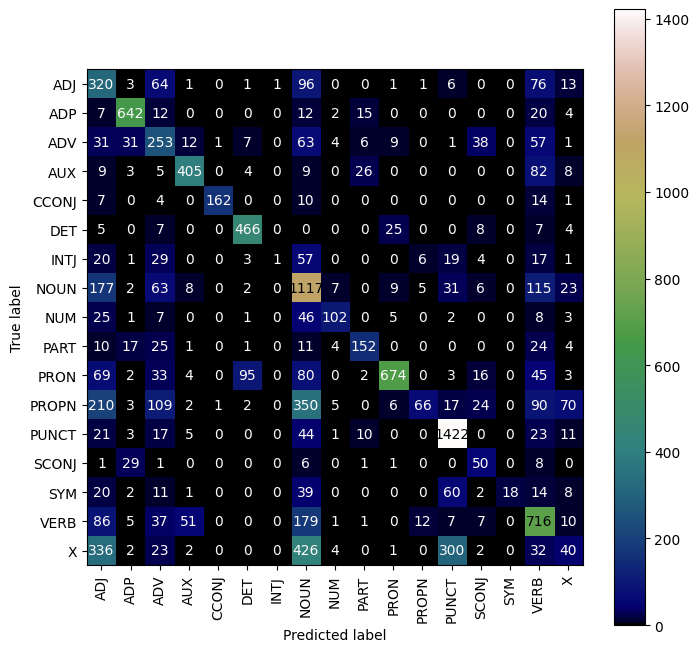

In [63]:
#create the confusion matrix
tags_set = sorted(set(all_tags))
cm = confusion_matrix(all_tags, all_predictions, labels=tags_set)
cm

#show the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags_set)
disp.plot(cmap="gist_earth", ax=ax, xticks_rotation="vertical")

plt.show()

# Spanish

In [64]:
lang = "Spanish"
ruta_archivo = f"output/od_{lang}_predictions.jsonl"

all_tags = []
all_predictions = []

# read de jsonl file and process it
with open(ruta_archivo, "r", encoding="utf-8") as archivo:
    contenido = archivo.read()
    contenido = "[" + contenido.strip().replace("}\n{", "},{") + "]"
    elementos = json.loads(contenido)
    #print(len(elementos[0]))

# get the tag and prediction of each instance and concatenate them
for elemento in elementos:
    if len(elemento.get("tags", [])) != len(elemento.get("prediction", [])):
        print(elemento.get("sentence"))
    all_tags.extend(elemento.get("tags", []))
    all_predictions.extend(elemento.get("prediction", []))

In [65]:
accuracy = accuracy_score(all_tags, all_predictions)
accuracy

0.640244772309194

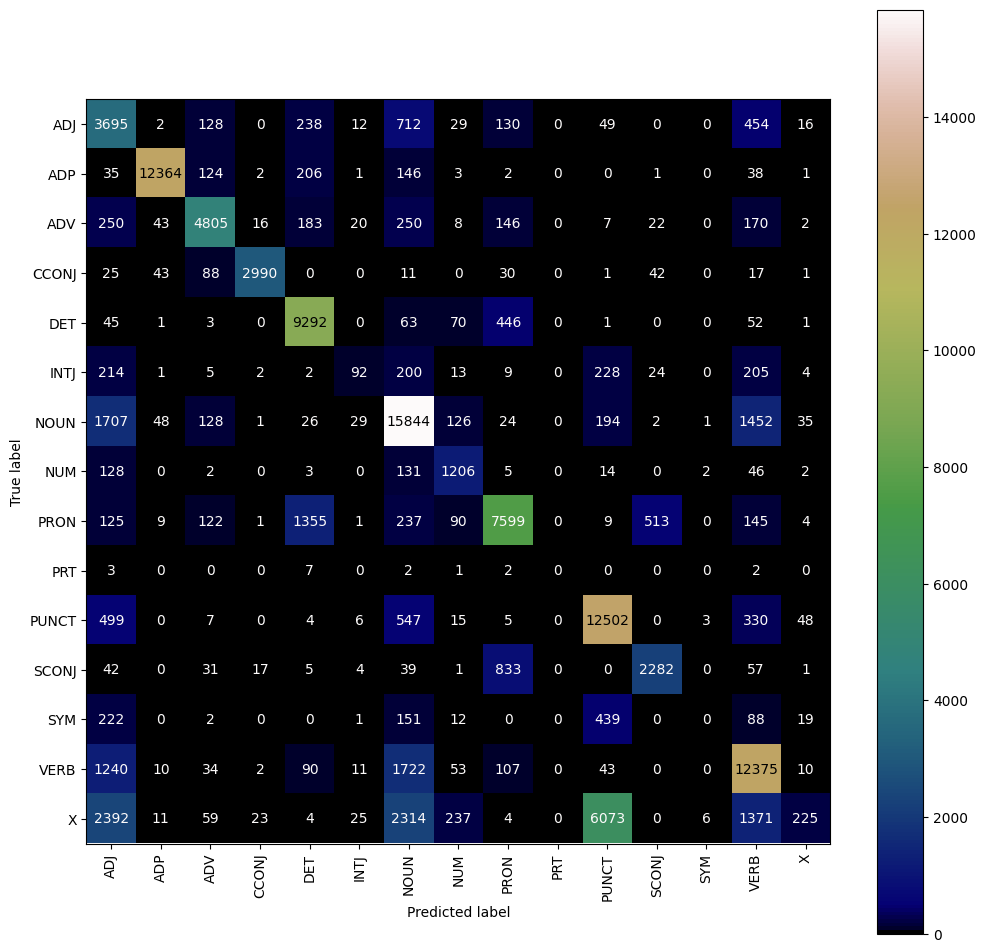

In [67]:
#create the confusion matrix
tags_set = sorted(set(all_tags))
cm = confusion_matrix(all_tags, all_predictions, labels=tags_set)
cm

#show the plot
fig, ax = plt.subplots(figsize=(12, 12))  # Adjust width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags_set)
disp.plot(cmap="gist_earth", ax=ax, xticks_rotation="vertical")

plt.show()